In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from pylab import rcParams

rcParams['figure.figsize'] = 20, 6
rcParams['axes.grid'] = True

# Load the dataset

In [2]:
df = [pd.read_json(f'../input/game-of-thrones-srt/season{i+1}.json') for i in range(7)]
df = pd.concat(df, axis=1)
print(df.shape)
df.head()

(983, 68)


,Game Of Thrones S01E01 Winter Is Coming.srt,Game Of Thrones S01E02 The Kingsroad.srt,Game Of Thrones S01E03 Lord Snow.srt,"Game Of Thrones S01E04 Cripples, Bastards, And Broken Things.srt",Game Of Thrones S01E05 The Wolf And The Lion.srt,Game Of Thrones S01E06 A Golden Crown.srt,Game Of Thrones S01E07 You Win Or You Die.srt,Game Of Thrones S01E08 The Pointy End.srt,Game Of Thrones S01E09 Baelor.srt,Game Of Thrones S01E10 Fire And Blood.srt,...,Game Of Thrones S06E08 No One.srt,Game Of Thrones S06E09 Battle of the Bastards.srt,Game Of Thrones S06E10 The Winds of Winter.srt,Game Of Thrones S07E01 Dragonstone.srt,Game Of Thrones S07E02 Stormborn.srt,Game Of Thrones S07E03 The Queen's Justice.srt,Game Of Thrones S07E04 The Spoils Of War.srt,Game Of Thrones S07E05 Eastwatch.srt,Game Of Thrones S07E06 Beyond The Wall.srt,Game Of Thrones S07E07 The Dragon And The Wolf.srt
1,"Easy, boy.","You need to drink, child.","Welcome, Lord Stark.",The little lord's been dreaming again.,Does Ser Hugh have any family in the capital?,"Your pardon, Your Grace.","""Summoned to court to answer for the crimes","Yah! Left high, left low.","You've seen better days, my lord.",Look at me. Look at me!,...,"<b><font color=""#00FF00"">♪ Game of Thrones 6x0...","Despite appearances, I think you'll find the c...",Your Grace.,♪ (PIANO PLAYING) ♪,ELLARIA: The Lannisters have declared war on h...,I wish you all the happiness in the world.,(GRUNTING),"Clegane, look into the flames.",LORD VARYS: Your father has proved to be an aw...,(GROANS)
2,What do you expect? They're savages.,And eat.,Grand Maester Pycelle has called a meeting of ...,- We have visitors. - I don't want to see anyone.,No.,"I would rise, but...","""of your bannerman Gregor Clegane, the Mountai...","Right low, lunge right.",Another visit?,"Do you remember me now, boy, eh?",...,"== sync, corrected by <font color=""#00FF00"">el...",Perhaps we should take shelter.,The trial will be getting under way soon.,♪ (PIANO STOPS) ♪,They have declared war on Dorne.,- JAIME LANNISTER: Myrcella? - (PANTING),I lost this dagger.,What do you see?,The girl is innocent. She should be given a ch...,Little Theon! Come and get her.
3,"One lot steals a goat from another lot,",Isn't there anything else?,The honour of your presence is requested.,Really? If I was cooped up all day,I stood vigil for him myself last night.,Do you know what your wife has done?,"""Arrive within the fortnight or be branded an ...","You break anything, the septa will have my head.",It seems you're my last friend.,Remember me? There's a bright boy.,...,<i>My son.</i>,The city's on the rise?,You got my money?,- (EXPLOSIONS) - (MAN YELLING),"We must be allies now, if we wish to survive.",Myrcella?,To whom?,THE HOUND: A wall of ice.,to prove her loyalty.,(CACKLES MANICALLY)
4,before you know it they're ripping each other ...,The Dothraki have two things in abundance - gr...,Get the girls settled in. I'll be back in time...,"with no one but this old bat for company, I'd ...",He had no one else.,- She did nothing I did not command. - Who'd h...,Poor Ned Stark.,What is...,"No, no, many still love you.","You'll be coming with me, boy, and you'll be k...",...,My firstborn son.,Meereen is strong.,Later. Go away.,♪ (PIANO PLAYING) ♪,I offer vengeance... justice...,(SCREAMS),Tyrion Lannister.,The Wall.,CERSEI LANNISTER: You must write to Lady Catelyn.,It's an invitation... to King's Landing.
5,I've never seen wildlings do a thing like this.,People can't live on grass.,"- And, Jory, you go with them. - Yes, my lord.","Anyway, you don't have a choice. Robb's waiting.",He'd never worn this armour before.,By what right dare you lay hands on my blood?,"Brave man, terrible judgment.",Your sister knew perfectly well we were to lea...,Sansa came to court this morning to plead for ...,"- Keep your mouth shut, boy. - I'm not a boy!",...,"My child king, hush.",Commerce has returned to the markets.,Grand Maester.,The war is over. Winter has come.,Fire and blood.,Kill us

In [3]:
df = pd.DataFrame(df.values.reshape(-1, 1), columns=['Script']).dropna().reset_index(drop=True)
df.head()

,Script
0,"Easy, boy."
1,"You need to drink, child."
2,"Welcome, Lord Stark."
3,The little lord's been dreaming again.
4,Does Ser Hugh have any family in the capital?


In [4]:
import re
cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def cleanhtml(raw_html):
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

df['Script'] = df['Script'].apply(cleanhtml)

In [5]:
text = '\n'.join(df['Script'].values)
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))

86 unique characters


# Process the text

## Vectorize the text
Before training, we need to map strings to a numerical representation. We create two lookup tables: one mapping characters to numbers, and another for numbers to characters.

In [6]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

## The prediction task
Given a character, or a sequence of characters, what is the most probable next character? This is the task we're training the model to perform. The input to the model will be a sequence of characters, and we train the model to predict the output—the following character at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the characters computed until this moment, what is the next character?

## Create training examples and targets
Next we divide the text into example sequences. Each input sequence will contain seq_length characters from the text.

For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So break the text into chunks of seq_length+1. For example, say seq_length is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".

To do this first use the `tf.data.Dataset.from_tensor_slices` function to convert the text vector into a stream of character indices.

In [7]:
import tensorflow as tf

In [8]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
    print(idx2char[i.numpy()])

E
a
s
y
,


The batch method lets us easily convert these individual characters to sequences of the desired size.

In [9]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

"Easy, boy.\nYou need to drink, child.\nWelcome, Lord Stark.\nThe little lord's been dreaming again.\nDoes"
' Ser Hugh have any family in the capital?\nYour pardon, Your Grace.\n"Summoned to court to answer for t'
"he crimes\nYah! Left high, left low.\nYou've seen better days, my lord.\nLook at me. Look at me!\nWell st"
"ruck.\nGotta be ready before nightfall.\nOut, all of you.\nIt's got to be the Mountain. He's the biggest"
".\n- You swear it? - By the mother.\nI've taken your castle.\nA cripple?\n- Riders approaching! - Open th"


For each sequence, duplicate and shift it to form the input and target text by using the map method to apply a simple function to each batch:

In [10]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

for input_example, target_example in  dataset.take(1):
    print('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  "Easy, boy.\nYou need to drink, child.\nWelcome, Lord Stark.\nThe little lord's been dreaming again.\nDoe"
Target data: "asy, boy.\nYou need to drink, child.\nWelcome, Lord Stark.\nThe little lord's been dreaming again.\nDoes"


Each index of these vectors is processed as a one time step. For the input at time step 0, the model receives the index for "E" and tries to predict the index for "a" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [11]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 32 ('E')
  expected output: 56 ('a')
Step    1
  input: 56 ('a')
  expected output: 74 ('s')
Step    2
  input: 74 ('s')
  expected output: 80 ('y')
Step    3
  input: 80 ('y')
  expected output: 9 (',')
Step    4
  input: 9 (',')
  expected output: 1 (' ')


## Create training batches

We used tf.data to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [12]:
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

# Build The Model

We'll use `keras.model.Sequential` to define the model. For this simple example three types of layers are used to define our model:

* `keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with embedding_dim dimensions;
* `keras.layers.GRU`: A type of RNN with size units=rnn_units (`keras.layers.LSTM` and `keras.layers.SimpleRNN` can also be used)
* `keras.layers.Dense`: The output layer, with vocab_size outputs

In [13]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = ['G1024']

In [14]:
from keras.models import Sequential, load_model
from keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model

In [15]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
filepath = "model.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

In [16]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]))
    for rnn_unit in rnn_units:
        layer_type = rnn_unit[0]
        num_cells = int(rnn_unit[1:])
        if layer_type == 'G':
            model.add(GRU(
                num_cells, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'
            ))
        elif layer_type == 'L':
            model.add(LSTM(
                num_cells, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'
            ))
        else:
            model.add(SimpleRNN(
                num_cells, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'
            ))

    model.add(Dense(vocab_size))
    return model

In [17]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE
)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![](https://www.tensorflow.org/tutorials/text/images/text_generation_training.png)

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to retrieve and reuse the states from stateful RNN layer, you might want to build your model with Keras functional API or model subclassing.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           22016     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 86)            88150     
Total params: 4,048,470
Trainable params: 4,048,470
Non-trainable params: 0
_________________________________________________________________


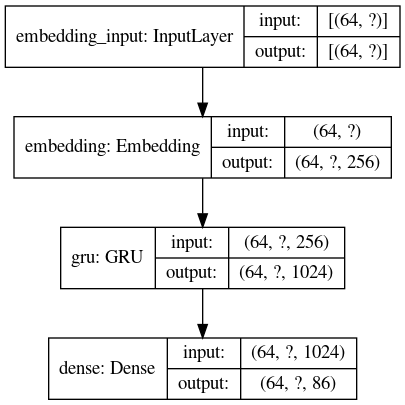

In [18]:
model.summary()
plot_model(model, show_shapes=True)

## Try the model
Now run the model to see that it behaves as expected.

First check the shape of the output:

In [19]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 86) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model you need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

Try it for the first example in the batch:

In [20]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

This gives us, at each timestep, a prediction of the next character index:

In [21]:
sampled_indices

array([76, 44,  5, 67, 79,  8, 83, 11,  1, 31, 69, 28,  2, 43, 15,  7, 77,
       40,  8, 22, 53, 21, 32, 22, 46, 37, 58,  7,  4, 67, 41, 56, 44, 38,
       75, 30, 16, 57, 22, 34, 50, 38, 22, 62, 48, 26, 55, 35, 39, 62, 55,
       72, 11, 81, 79, 39, 12, 23, 49,  9, 69, 57, 74, 45, 77, 27, 45, 68,
       28, 36, 67, 36, 67, 56, 77, 66, 52, 50,  1,  8, 64,  8, 54, 79, 70,
       69, 58, 25,  9, 36, 76, 14,  1,  3,  6, 65, 66, 44, 51, 55])

In [22]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 ' of battle.\nAnd I am an excellent judge of character.\nTogether, we will save this country\nI almost d'

Next Char Predictions: 
 'uQ&lx)í. DnA!P3(vM):Z9E:SJc(#lNaQKtC4b:GWK:gU?`HLg`q.zxL0;V,nbsRv@RmAIlIlavkYW )i)_xonc>,Iu2 "\'jkQX`'


# Train the model
At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

## Attach an optimizer, and a loss function
The standard `tf.keras.losses.sparse_categorical_crossentropy` loss function works in this case because it is applied across the last dimension of the predictions.

Because your model returns logits, you need to set the from_logits flag.

In [23]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 86)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.45373


Configure the training procedure using the `tf.keras.Model.compile` method. Use `tf.keras.optimizers.Adam` with default arguments and the loss function.

In [24]:
model.compile(optimizer='adam', loss=loss)

Epoch 1/500
231/232 [============================>.] - ETA: 0s - loss: 2.4689
Epoch 00001: loss improved from inf to 2.46673, saving model to model.h5
232/232 [==============================] - 11s 46ms/step - loss: 2.4667
Epoch 2/500
231/232 [============================>.] - ETA: 0s - loss: 1.7472
Epoch 00002: loss improved from 2.46673 to 1.74640, saving model to model.h5
232/232 [==============================] - 11s 46ms/step - loss: 1.7464
Epoch 3/500
231/232 [============================>.] - ETA: 0s - loss: 1.4711
Epoch 00003: loss improved from 1.74640 to 1.47077, saving model to model.h5
232/232 [==============================] - 10s 45ms/step - loss: 1.4708
Epoch 4/500
232/232 [==============================] - ETA: 0s - loss: 1.3473
Epoch 00004: loss improved from 1.47077 to 1.34729, saving model to model.h5
232/232 [==============================] - 10s 45ms/step - loss: 1.3473
Epoch 5/500
231/232 [============================>.] - ETA: 0s - loss: 1.2783
Epoch 00005: loss 

Epoch 37/500
231/232 [============================>.] - ETA: 0s - loss: 0.7480
Epoch 00037: loss did not improve from 0.74109
232/232 [==============================] - 11s 46ms/step - loss: 0.7482
Epoch 38/500
231/232 [============================>.] - ETA: 0s - loss: 0.7486
Epoch 00038: loss did not improve from 0.74109
232/232 [==============================] - 10s 45ms/step - loss: 0.7488
Epoch 39/500
231/232 [============================>.] - ETA: 0s - loss: 0.7487
Epoch 00039: loss did not improve from 0.74109

Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
232/232 [==============================] - 11s 45ms/step - loss: 0.7488
Epoch 40/500
231/232 [============================>.] - ETA: 0s - loss: 0.6525
Epoch 00040: loss improved from 0.74109 to 0.65240, saving model to model.h5
232/232 [==============================] - 10s 45ms/step - loss: 0.6524
Epoch 41/500
231/232 [============================>.] - ETA: 0s - loss: 0.5910
Epoch 00041: loss

Epoch 73/500
232/232 [==============================] - ETA: 0s - loss: 0.3927
Epoch 00073: loss improved from 0.39528 to 0.39273, saving model to model.h5
232/232 [==============================] - 10s 45ms/step - loss: 0.3927
Epoch 74/500
231/232 [============================>.] - ETA: 0s - loss: 0.3912
Epoch 00074: loss improved from 0.39273 to 0.39122, saving model to model.h5
232/232 [==============================] - 10s 45ms/step - loss: 0.3912
Epoch 75/500
231/232 [============================>.] - ETA: 0s - loss: 0.3883
Epoch 00075: loss improved from 0.39122 to 0.38828, saving model to model.h5
232/232 [==============================] - 11s 45ms/step - loss: 0.3883
Epoch 76/500
232/232 [==============================] - ETA: 0s - loss: 0.3876
Epoch 00076: loss improved from 0.38828 to 0.38761, saving model to model.h5
232/232 [==============================] - 11s 45ms/step - loss: 0.3876
Epoch 77/500
232/232 [==============================] - ETA: 0s - loss: 0.3857
Epoch 000

231/232 [============================>.] - ETA: 0s - loss: 0.3257
Epoch 00152: loss did not improve from 0.32559
232/232 [==============================] - 11s 46ms/step - loss: 0.3257
Epoch 153/500
231/232 [============================>.] - ETA: 0s - loss: 0.3251
Epoch 00153: loss improved from 0.32559 to 0.32506, saving model to model.h5
232/232 [==============================] - 11s 47ms/step - loss: 0.3251
Epoch 154/500
231/232 [============================>.] - ETA: 0s - loss: 0.3256
Epoch 00154: loss did not improve from 0.32506
232/232 [==============================] - 10s 45ms/step - loss: 0.3255
Epoch 155/500
232/232 [==============================] - ETA: 0s - loss: 0.3249
Epoch 00155: loss improved from 0.32506 to 0.32492, saving model to model.h5
232/232 [==============================] - 10s 45ms/step - loss: 0.3249
Epoch 156/500
231/232 [============================>.] - ETA: 0s - loss: 0.3237
Epoch 00156: loss improved from 0.32492 to 0.32371, saving model to model.h5
2

Epoch 190/500
231/232 [============================>.] - ETA: 0s - loss: 0.3051
Epoch 00190: loss did not improve from 0.30399

Epoch 00190: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
232/232 [==============================] - 10s 45ms/step - loss: 0.3050
Epoch 191/500
231/232 [============================>.] - ETA: 0s - loss: 0.3038
Epoch 00191: loss improved from 0.30399 to 0.30380, saving model to model.h5
232/232 [==============================] - 11s 45ms/step - loss: 0.3038
Epoch 192/500
232/232 [==============================] - ETA: 0s - loss: 0.3034
Epoch 00192: loss improved from 0.30380 to 0.30335, saving model to model.h5
232/232 [==============================] - 10s 45ms/step - loss: 0.3034
Epoch 193/500
232/232 [==============================] - ETA: 0s - loss: 0.3036
Epoch 00193: loss did not improve from 0.30335
232/232 [==============================] - 11s 46ms/step - loss: 0.3036
Epoch 194/500
231/232 [============================>.] - ETA: 

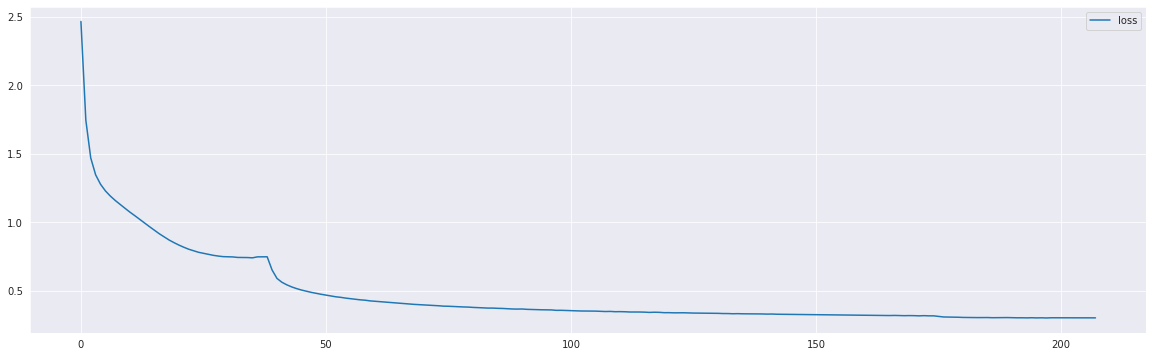

In [25]:
EPOCHS = 500
history = model.fit(dataset, epochs=EPOCHS, callbacks=[es, ckpt, rlp])
pd.DataFrame(history.history)[['loss']].plot();

# Generate text

The following code block generates the text:

* Begin by choosing a start string, initializing the RNN state and setting the number of characters to generate.

* Get the prediction distribution of the next character using the start string and the RNN state.

* Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

* The RNN state returned by the model is fed back into the model so that it now has more context, instead of only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

![](https://www.tensorflow.org/tutorials/text/images/text_generation_sampling.png)

In [26]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(filepath)
model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            22016     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_1 (Dense)              (1, None, 86)             88150     
Total params: 4,048,470
Trainable params: 4,048,470
Non-trainable params: 0
_________________________________________________________________


In [27]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [28]:
print(generate_text(model, start_string="Seven Hells"))

Seven Hells me.
Go on, girls. Get your hands off your freedom.
The white walkers
Green girls have important to me.
I'm not dead yet, you know.
And he said this to you alive, we're our help.
He couldn't know.
And you s and took the Seven Kingdoms.
And what is their sigil?
Bastard, come here.
I don't want what I was doing wash yourself.
I'm not living.
My mother does raise the wolf again.
Viserys are dead.
The whole shit isalf.
Our queen knows it is a tortured liar.
He's a dragon. I have something for you.
Archmaester, I won't tell you.
What was he like?
Your pardon, my lordsy means men fighting, Jon Snow.
A girl and that's where you come in?
And with little man must win at me,
Or I'd be long need you.
Those men, they said my father knew what they were to r most for you his subjects for the piece of pardon.
You can't let her suffer.
Once Oberyn gave me "my lion.
- You would not have my honour?
I'll not sit meekly by... and wet will be all, Lord Arryn.
give it to our vows hurry?
You gave 

Reference: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation)